**We are given datasets from two websites we need to forecast the number of visitors to the restaurant for AirREGI / Restaurant Board (air) site.**
**The Other website Hot Pepper Gourmet (hpg) information is useful because some restaurants are present in two sites**


In [1]:
import numpy as np
import pandas as pd
import pandasql as ps
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import os
from zipfile import ZipFile
%matplotlib inline

In [2]:
pd.set_option('display.max_columns' ,None)

In [3]:
def fix_random(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.compat.v1.set_random_seed(seed)
    tf.random.set_seed(seed)

In [4]:
DIR='../input/recruit-restaurant-visitor-forecasting'

In [5]:
for curr,folders,files in os.walk(DIR):
    for file in files:
        if file!="recruit-restaurant-visitor-forecasting.zip":
            if file.endswith(".zip"):
                f=ZipFile(os.path.join(curr,file))
                f.extractall()
                f.close()

In [6]:
air_visit=pd.read_csv("air_visit_data.csv")
air_res=pd.read_csv("air_reserve.csv")
air_info=pd.read_csv("air_store_info.csv")
##########################################
hpg_res=pd.read_csv('hpg_reserve.csv')
hpg_info=pd.read_csv('hpg_store_info.csv')
##########################################
date_info=pd.read_csv("date_info.csv")
stores_map=pd.read_csv('store_id_relation.csv')

main table

In [7]:
air_visit.head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


restaurants which are present in both websites

In [8]:
stores_map.head()

,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7


table contains restaurant id, visit date(when the customer vists), reserve date(when the reservation is made) and number of customers booked

In [9]:
air_res.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


In [10]:
hpg_res.head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13


In [11]:
hpg_res=pd.merge(left=hpg_res,right=stores_map,left_on="hpg_store_id",right_on='hpg_store_id',how='inner')

In [12]:
hpg_res.drop("hpg_store_id",axis=1,inplace=True)
reservations=pd.concat([air_res,hpg_res],ignore_index=True)

In [13]:
reservations.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


In [14]:
def make_datetime_to_date(dataframe):
    dataframe['visit_datetime']=pd.to_datetime(dataframe['visit_datetime'])
    dataframe['reserve_datetime']=pd.to_datetime(dataframe['reserve_datetime'])
    dataframe['n_days_gap']=dataframe.apply(lambda x: (x['visit_datetime']-x['reserve_datetime']).days,axis=1)
    dataframe["n_hrs_gap"]=dataframe.apply(lambda x: (x['visit_datetime']-x['reserve_datetime']).total_seconds()/3600.0,axis=1)
    dataframe["visit_date"]=dataframe['visit_datetime'].dt.date
    dataframe.drop(['visit_datetime',"reserve_datetime"],axis=1,inplace=True)
    return dataframe

In [15]:
reservations=make_datetime_to_date(reservations)

In [16]:
reservations.head()

,air_store_id,reserve_visitors,n_days_gap,n_hrs_gap,visit_date
0,air_877f79706adbfb06,1,0,3.0,2016-01-01
1,air_db4b38ebe7a7ceff,3,0,0.0,2016-01-01
2,air_db4b38ebe7a7ceff,6,0,0.0,2016-01-01
3,air_877f79706adbfb06,2,0,4.0,2016-01-01
4,air_db80363d35f10926,5,0,19.0,2016-01-01


info about the cuisines and near location of the restaurants

In [17]:
air_info.head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [18]:
hpg_info.head()

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


In [19]:
hpg_info=pd.merge(left=hpg_info,right=stores_map,left_on="hpg_store_id",right_on='hpg_store_id',how='inner')

In [20]:
hpg_info.rename(columns={"hpg_genre_name":"air_genre_name","hpg_area_name":"air_area_name"},inplace=True)
hpg_info.drop("hpg_store_id",axis=1,inplace=True)

In [21]:
information=pd.concat([air_info,hpg_info],ignore_index=True)

calender

In [22]:
date_info.head()

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


In [23]:
reservations.duplicated(subset=["air_store_id","visit_date"]).unique()

array([False,  True])

In [24]:
information.duplicated(subset=["air_store_id"]).unique()

array([False,  True])

In [25]:
new_cols=["air_store_id","visit_date"]
for col in ['reserve_visitors','n_hrs_gap','n_days_gap']:
    for agg in ['mean','max','min','sum']:
        new_cols.append(col+"_"+agg)

In [26]:
reservations=reservations.groupby(["air_store_id","visit_date"]).agg({"reserve_visitors":["mean","max","min","sum"],
                                                        "n_hrs_gap":["mean","max","min","sum"],
                                                        "n_days_gap":["mean","max","min","sum"]}).reset_index()

In [27]:
reservations.columns=new_cols

In [28]:
reservations['visit_date']=pd.to_datetime(reservations['visit_date'])
reservations.sort_values(by=['air_store_id','visit_date'],ignore_index=True,inplace=True)

In [29]:
cols=['reserve_visitors_sum',"n_hrs_gap_sum","n_days_gap_sum"]
for col in cols:
    for window in [7,14,30]:
        reservations[f"{col}_rolling_{window}_mean"]=reservations.groupby("air_store_id")[col].transform(lambda x: x.rolling(window).mean())
        reservations[f"{col}_rolling_{window}_std"] =reservations.groupby("air_store_id")[col].transform(lambda x: x.rolling(window).std())
        reservations[f"{col}_rolling_{window}_max"] =reservations.groupby("air_store_id")[col].transform(lambda x: x.rolling(window).max())
        reservations[f"{col}_rolling_{window}_min"] =reservations.groupby("air_store_id")[col].transform(lambda x: x.rolling(window).min())

In [30]:
reservations.sort_values(by=['air_store_id','visit_date'],ignore_index=True,inplace=True)

In [31]:
cols=['reserve_visitors_sum',"n_hrs_gap_sum","n_days_gap_sum"]
for col in cols:
    for lag in range(1,8):
        reservations[f"{col}_lag_{lag}"]=reservations.groupby("air_store_id")[col].transform(lambda x: x.shift(lag))        

In [32]:
reservations.head(10)

,air_store_id,visit_date,reserve_visitors_mean,reserve_visitors_max,reserve_visitors_min,reserve_visitors_sum,n_hrs_gap_mean,n_hrs_gap_max,n_hrs_gap_min,n_hrs_gap_sum,n_days_gap_mean,n_days_gap_max,n_days_gap_min,n_days_gap_sum,reserve_visitors_sum_rolling_7_mean,reserve_visitors_sum_rolling_7_std,reserve_visitors_sum_rolling_7_max,reserve_visitors_sum_rolling_7_min,reserve_visitors_sum_rolling_14_mean,reserve_visitors_sum_rolling_14_std,reserve_visitors_sum_rolling_14_max,reserve_visitors_sum_rolling_14_min,reserve_visitors_sum_rolling_30_mean,reserve_visitors_sum_rolling_30_std,reserve_visitors_sum_rolling_30_max,reserve_visitors_sum_rolling_30_min,n_hrs_gap_sum_rolling_7_mean,n_hrs_gap_sum_rolling_7_std,n_hrs_gap_sum_rolling_7_max,n_hrs_gap_sum_rolling_7_min,n_hrs_gap_sum_rolling_14_mean,n_hrs_gap_sum_rolling_14_std,n_hrs_gap_sum_rolling_14_max,n_hrs_gap_sum_rolling_14_min,n_hrs_gap_sum_rolling_30_mean,n_hrs_gap_sum_rolling_30_std,n_hrs_gap_sum_rolling_30_max,n_hrs_gap_sum_rolling_30_min,n_days_gap_sum_rolling_7_mean,n_days_gap_sum_rolling_7_std,n_days_gap_sum_rolling_7_max,n_days_gap_sum_rolling_7_min,n_days_gap_sum_rolling_14_mean,n_days_gap_sum_rolling_14_std,n_days_gap_sum_rolling_14_max,n_days_gap_sum_rolling_14_min,n_days_gap_sum_rolling_30_mean,n_days_gap_sum_rolling_30_std,n_days_gap_sum_rolling_30_max,n_days_gap_sum_rolling_30_min,reserve_visitors_sum_lag_1,reserve_visitors_sum_lag_2,reserve_visitors_sum_lag_3,reserve_visitors_sum_lag_4,reserve_visitors_sum_lag_5,reserve_visitors_sum_lag_6,reserve_visitors_sum_lag_7,n_hrs_gap_sum_lag_1,n_hrs_gap_sum_lag_2,n_hrs_gap_sum_lag_3,n_hrs_gap_sum_lag_4,n_hrs_gap_sum_lag_5,n_hrs_gap_sum_lag_6,n_hrs_gap_sum_lag_7,n_days_gap_sum_lag_1,n_days_gap_sum_lag_2,n_days_gap_sum_lag_3,n_days_gap_sum_lag_4,n_days_gap_sum_lag_5,n_days_gap_sum_lag_6,n_days_gap_sum_lag_7
0,air_00a91d42b08b08d9,2016-01-14,2.0,2,2,2,77.0,77.0,77.0,77.0,3.0,3,3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,air_00a91d42b08b08d9,2016-01-15,4.0,4,4,4,142.0,142.0,142.0,142.0,5.0,5,5,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,77.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
2,air_00a91d42b08b08d9,2016-01-16,2.0,2,2,2,70.0,70.0,70.0,70.0,2.0,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,2.0,NaN,NaN,NaN,NaN,NaN,142.0,77.0,NaN,NaN,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,NaN,NaN
3,air_00a91d42b08b08d9,2016-01-22,2.0,2,2,2,82.0,82.0,82.0,82.0,3.0,3,3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,4.0,2.0,NaN,NaN,NaN,NaN,70.0,142.0,77.0,NaN,NaN,NaN,NaN,2.0,5.0,3.0,NaN,NaN,NaN,NaN
4,air_00a91d42b08b08d9,2016-01-29,5.0,5,5,5,144.0,144.0,144.0,144.0,6.0,6,6,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,4.0,2.0,NaN,NaN,NaN,82.0,70.0,142.0,77.0,NaN,NaN,NaN,3.0,2.0,5.0,3.0,NaN,NaN,NaN
5,air_00a91d42b08b08d9,2016-02-05,2.0,2,2,2,385.0,385.0,385.0,385.0,16.0,16,16,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,2.0,2.0,4.0,2.0,NaN,NaN,144.0,82.0,70.0,142.0,77.0,NaN,NaN,6.0,3.0,2.0,5.0,3.0,NaN,NaN
6,air_00a91d42b08b08d9,2016-03-08,3.0,3,3,3,50.0,50.0,50.0,50.0,2.0,2,2,2,2.857143,1.214986,5.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,135.714286,115.649923,385.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.285714,4.956958,16.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,5.0,2.0,2.0,4.0,2.0,NaN,385.0,144.0,82.0,70.0,142.0

In [33]:
information=information.groupby("air_store_id").agg({"air_genre_name":"unique","air_area_name":"unique"}).reset_index()

In [34]:
def get_cuisines(genres):
    l=[]
    for g in genres:
        gs=g.split("/")
        l.extend(gs)
    return list(set(l))

In [35]:
information['n_areas']=information['air_area_name'].apply(lambda x: len(x))

In [36]:
information['n_areas'].unique()

array([1, 2])

# some stores are present at two places


In [37]:
AREA_SPLIT=False

In [38]:
if AREA_SPLIT:
    information['first_area'] =information['air_area_name'].apply(lambda x: x[0])
    information['second_area']=information['air_area_name'].apply(lambda x: x[1] if len(x)>1 else "only at one area")
else:
    information['air_area_name']=information['air_area_name'].apply(lambda x: ",".join(x))

In [39]:
information['air_genre_name']=information['air_genre_name'].apply(get_cuisines)

In [40]:
information.head()

,air_store_id,air_genre_name,air_area_name,n_areas
0,air_00a91d42b08b08d9,"[Italian, French]",Tōkyō-to Chiyoda-ku Kudanminami,1
1,air_0164b9927d20bcc3,"[Italian, French]",Tōkyō-to Minato-ku Shibakōen,1
2,air_0241aa3964b7f861,[Izakaya],Tōkyō-to Taitō-ku Higashiueno,1
3,air_0328696196e46f18,[Dining bar],Ōsaka-fu Ōsaka-shi Nakanochō,1
4,air_034a3d5b40d5b1b1,"[Sweets, Cafe]",Ōsaka-fu Ōsaka-shi Ōhiraki,1


In [41]:
if AREA_SPLIT:
    information.drop(['air_area_name'],axis=1,inplace=True)

In [42]:
from sklearn.preprocessing import MultiLabelBinarizer,LabelEncoder,StandardScaler

In [43]:
if AREA_SPLIT:
    areas=information['first_area'].unique().tolist()
    areas.extend(information['second_area'].unique().tolist())
else:
    areas=information['air_area_name'].unique().tolist()

In [44]:
area_encoder=LabelEncoder()
area_encoder.fit(areas)
if AREA_SPLIT:
    information['first_area']=area_encoder.transform(information['first_area'])
    information['second_area']=area_encoder.transform(information['second_area'])
else:
    information['air_area_name']=area_encoder.transform(information['air_area_name'])
##########################################
if AREA_SPLIT:
    cuisine_encoder=MultiLabelBinarizer()
    cuisine_encoder.fit(information['air_genre_name'])
    temp=pd.DataFrame(cuisine_encoder.transform(information['air_genre_name']),columns=list(cuisine_encoder.classes_))
    information=information.join(temp)
    information.drop("air_genre_name",axis=1,inplace=True)
else:
    cuisine_encoder=LabelEncoder()
    information['air_genre_name']=information['air_genre_name'].apply(lambda x: ",".join(x))
    information['air_genre_name']=cuisine_encoder.fit_transform(information['air_genre_name'])

In [45]:
if AREA_SPLIT:
    information['Asian'].value_counts()
    information.loc[information['Asian']==1,"first_area"].unique(),information.loc[information['Asian']==1,"second_area"].unique()

In [46]:
if AREA_SPLIT:
    for c in list(cuisine_encoder.classes_):
        sec={c:information.groupby('second_area')[c].transform("sum").values,"sec":information['second_area'].values}
        sec=pd.DataFrame(sec)
        sec.loc[sec['sec']==119,c]=0
        information[f"n_rest_of_{c}_per_area"]=information.groupby('first_area')[c].transform("sum")+sec[c]
else:
    information['count_res_per_genre_area']=information.groupby(['air_area_name','air_genre_name'])['air_store_id'].transform("count")
    information['count_genres_per_area']=information.groupby(['air_area_name'])['air_genre_name'].transform("count")

In [47]:
if AREA_SPLIT:
    sec=pd.DataFrame({"n_res":information.groupby("second_area")['air_store_id'].transform("count").values,
                  "sec":information['second_area'].values})
    sec.loc[sec['sec']==119,'n_res']=0
    information["n_restaurants_per_area"]=information.groupby("first_area")['air_store_id'].transform("count")+sec['n_res']

In [48]:
date_info['calendar_date']=pd.to_datetime(date_info['calendar_date'])

In [49]:
date_info.groupby('day_of_week')['holiday_flg'].sum()

day_of_week
Friday       5
Monday       9
Saturday     5
Sunday       4
Thursday     7
Tuesday      2
Wednesday    3
Name: holiday_flg, dtype: int64

In [50]:
date_info['day_of_week'].value_counts()

Friday       74
Saturday     74
Sunday       74
Monday       74
Tuesday      74
Wednesday    74
Thursday     73
Name: day_of_week, dtype: int64

In [51]:
date_info.loc[date_info['day_of_week'].isin(['Saturday','Sunday']),"holiday_flg"]=1

made sunday, saturdays as holidays

In [52]:
date_info.groupby('day_of_week')['holiday_flg'].sum()

day_of_week
Friday        5
Monday        9
Saturday     74
Sunday       74
Thursday      7
Tuesday       2
Wednesday     3
Name: holiday_flg, dtype: int64

# golden week in japan starts from April 29 and ends at 5th may and sometimes goes to 6th may.
# So below we are making holiday from 29th April to 5th May and we will make 6th May as holiday when 7h May is also holiday.

In [53]:
date_info['month']=date_info['calendar_date'].dt.month
date_info['day']=date_info['calendar_date'].dt.day
for i in date_info.loc[((date_info['month']==4) & (date_info['day']>=29)) | ((date_info['month']==5) & (date_info['day']<=7))].index:
    day=date_info.loc[i,'day']
    if day not in [6,7]:
        date_info.loc[i,'holiday_flg']=1
    else:
        if day==6:
            if date_info.loc[i+1,'day']==7 and date_info.loc[i+1,'holiday_flg']==1:
                date_info.loc[i,'holiday_flg']=1

In [54]:
date_info.loc[((date_info['month']==4) & (date_info['day']>=29)) | ((date_info['month']==5) & (date_info['day']<=7))]

,calendar_date,day_of_week,holiday_flg,month,day
119,2016-04-29,Friday,1,4,29
120,2016-04-30,Saturday,1,4,30
121,2016-05-01,Sunday,1,5,1
122,2016-05-02,Monday,1,5,2
123,2016-05-03,Tuesday,1,5,3
124,2016-05-04,Wednesday,1,5,4
125,2016-05-05,Thursday,1,5,5
126,2016-05-06,Friday,1,5,6
127,2016-05-07,Saturday,1,5,7
484,2017-04-29,Saturday,1,4,29


# creating feature which tells consecutive holidays

In [55]:
q='''
with f_cte as
(
select a.calendar_date,b.calendar_date as sec,b.holiday_flg,a.day_of_week,a.month,a.day
from date_info a
inner join
date_info b
on b.calendar_date>=a.calendar_date and (a.holiday_flg=1 and b.holiday_flg=1)
),final_cte as
(
select *,row_number() over(partition by calendar_date order by sec) as row_id
from
(
select *,julianday(sec)-julianday(calendar_date) as diff
from f_cte
) a
)
select *,sum(holiday_flg) as n_holidays
from final_cte
where row_id-diff=1
group by calendar_date


'''
a=ps.sqldf(q)
a.loc[((a['month']==4) & (a['day']>=29)) | ((a['month']==5) & (a['day']<=7))]

,calendar_date,sec,holiday_flg,day_of_week,month,day,diff,row_id,n_holidays
38,2016-04-29 00:00:00.000000,2016-04-29 00:00:00.000000,1,Friday,4,29,0.0,1,10
39,2016-04-30 00:00:00.000000,2016-04-30 00:00:00.000000,1,Saturday,4,30,0.0,1,9
40,2016-05-01 00:00:00.000000,2016-05-01 00:00:00.000000,1,Sunday,5,1,0.0,1,8
41,2016-05-02 00:00:00.000000,2016-05-02 00:00:00.000000,1,Monday,5,2,0.0,1,7
42,2016-05-03 00:00:00.000000,2016-05-03 00:00:00.000000,1,Tuesday,5,3,0.0,1,6
43,2016-05-04 00:00:00.000000,2016-05-04 00:00:00.000000,1,Wednesday,5,4,0.0,1,5
44,2016-05-05 00:00:00.000000,2016-05-05 00:00:00.000000,1,Thursday,5,5,0.0,1,4
45,2016-05-06 00:00:00.000000,2016-05-06 00:00:00.000000,1,Friday,5,6,0.0,1,3
46,2016-05-07 00:00:00.000000,2016-05-07 00:00:00.000000,1,Saturday,5,7,0.0,1,2
163,2017-04-29 00:00:00.000000,2017-04-29 00:00:00.000000,1,Saturday,4,29,0.0,1,9


In [56]:
a['calendar_date']=pd.to_datetime(a['calendar_date'])
a.drop(['sec','holiday_flg','day_of_week','month','day','diff','row_id'],axis=1,inplace=True)
a.head()

,calendar_date,n_holidays
0,2016-01-01,3
1,2016-01-02,2
2,2016-01-03,1
3,2016-01-09,3
4,2016-01-10,2


In [57]:
date_info=pd.merge(left=date_info,right=a,left_on='calendar_date',right_on='calendar_date',how='left')
date_info['n_holidays'].fillna(0,inplace=True)
date_info.drop(['day_of_week','month','day'],axis=1,inplace=True)

# we found remaining holidays at respective date. Now lets find how long the vacation is?

In [58]:
q='''
with f_cte as
(
select *,(select min(b.calendar_date)
          from date_info b
          where b.calendar_date>=a.calendar_date and b.holiday_flg!=a.holiday_flg) as max_date
from date_info a
),final_cte as
(
select a.calendar_date,a.holiday_flg,a.n_holidays,a.max_date,b.calendar_date as temp_date
from f_cte a
left join
f_cte b
on a.max_date=b.max_date
),last_cte as
(
select calendar_date,holiday_flg,n_holidays,max_date,julianday(max_date)-julianday(min(temp_date)) as temp_vacation_length
from final_cte
group by calendar_date,holiday_flg,n_holidays,max_date
)
select calendar_date,holiday_flg,n_holidays,
       (case when holiday_flg=1 then temp_vacation_length
       else 0
       end) as vacation_length
from last_cte
'''
date_info=ps.sqldf(q)

In [59]:
date_info['calendar_date']=pd.to_datetime(date_info['calendar_date'])

In [60]:
date_info['month']=date_info['calendar_date'].dt.month
date_info['day']=date_info['calendar_date'].dt.day
date_info.loc[((date_info['month']==4) & (date_info['day']>=29)) | ((date_info['month']==5) & (date_info['day']<=7))]

,calendar_date,holiday_flg,n_holidays,vacation_length,month,day
119,2016-04-29,1,10.0,10.0,4,29
120,2016-04-30,1,9.0,10.0,4,30
121,2016-05-01,1,8.0,10.0,5,1
122,2016-05-02,1,7.0,10.0,5,2
123,2016-05-03,1,6.0,10.0,5,3
124,2016-05-04,1,5.0,10.0,5,4
125,2016-05-05,1,4.0,10.0,5,5
126,2016-05-06,1,3.0,10.0,5,6
127,2016-05-07,1,2.0,10.0,5,7
484,2017-04-29,1,9.0,9.0,4,29


In [61]:
date_info.drop(['month','day'],axis=1,inplace=True)

In [62]:
air_visit['visit_date']=pd.to_datetime(air_visit['visit_date'])

In [63]:
air_visit=pd.merge(left=air_visit,right=date_info,left_on="visit_date",right_on='calendar_date',how='left')
air_visit.drop(['calendar_date'],axis=1,inplace=True)

In [64]:
air_visit['visit_month']=air_visit['visit_date'].dt.month
air_visit['visit_dow']=air_visit['visit_date'].dt.dayofweek
air_visit['visit_day']=air_visit['visit_date'].dt.day

In [65]:
air_visit['air_store_id'].nunique(),reservations['air_store_id'].nunique()

(829, 333)

In [66]:
air_visit['air_store_id'].nunique(),information['air_store_id'].nunique()

(829, 829)

In [67]:
air_visit=pd.merge(left=air_visit,right=reservations,left_on=['air_store_id','visit_date'],right_on=['air_store_id','visit_date'],how='left')
air_visit=pd.merge(left=air_visit,right=information,left_on='air_store_id',right_on='air_store_id',how='left')

# create lag features of target and rolling window features of target

In [68]:
air_visit.sort_values(by=['air_store_id','visit_date'],ignore_index=True,inplace=True)

In [69]:
cols=["visitors"]
for col in cols:
    for lag in range(1,8):
        air_visit[f"{col}_lag_{lag}"]=air_visit.groupby("air_store_id")[col].transform(lambda x: x.shift(lag))  

In [70]:
restaurant_encoder=LabelEncoder()
air_visit['air_store_id']=restaurant_encoder.fit_transform(air_visit['air_store_id'])

In [71]:
air_visit.head(10)

,air_store_id,visit_date,visitors,holiday_flg,n_holidays,vacation_length,visit_month,visit_dow,visit_day,reserve_visitors_mean,reserve_visitors_max,reserve_visitors_min,reserve_visitors_sum,n_hrs_gap_mean,n_hrs_gap_max,n_hrs_gap_min,n_hrs_gap_sum,n_days_gap_mean,n_days_gap_max,n_days_gap_min,n_days_gap_sum,reserve_visitors_sum_rolling_7_mean,reserve_visitors_sum_rolling_7_std,reserve_visitors_sum_rolling_7_max,reserve_visitors_sum_rolling_7_min,reserve_visitors_sum_rolling_14_mean,reserve_visitors_sum_rolling_14_std,reserve_visitors_sum_rolling_14_max,reserve_visitors_sum_rolling_14_min,reserve_visitors_sum_rolling_30_mean,reserve_visitors_sum_rolling_30_std,reserve_visitors_sum_rolling_30_max,reserve_visitors_sum_rolling_30_min,n_hrs_gap_sum_rolling_7_mean,n_hrs_gap_sum_rolling_7_std,n_hrs_gap_sum_rolling_7_max,n_hrs_gap_sum_rolling_7_min,n_hrs_gap_sum_rolling_14_mean,n_hrs_gap_sum_rolling_14_std,n_hrs_gap_sum_rolling_14_max,n_hrs_gap_sum_rolling_14_min,n_hrs_gap_sum_rolling_30_mean,n_hrs_gap_sum_rolling_30_std,n_hrs_gap_sum_rolling_30_max,n_hrs_gap_sum_rolling_30_min,n_days_gap_sum_rolling_7_mean,n_days_gap_sum_rolling_7_std,n_days_gap_sum_rolling_7_max,n_days_gap_sum_rolling_7_min,n_days_gap_sum_rolling_14_mean,n_days_gap_sum_rolling_14_std,n_days_gap_sum_rolling_14_max,n_days_gap_sum_rolling_14_min,n_days_gap_sum_rolling_30_mean,n_days_gap_sum_rolling_30_std,n_days_gap_sum_rolling_30_max,n_days_gap_sum_rolling_30_min,reserve_visitors_sum_lag_1,reserve_visitors_sum_lag_2,reserve_visitors_sum_lag_3,reserve_visitors_sum_lag_4,reserve_visitors_sum_lag_5,reserve_visitors_sum_lag_6,reserve_visitors_sum_lag_7,n_hrs_gap_sum_lag_1,n_hrs_gap_sum_lag_2,n_hrs_gap_sum_lag_3,n_hrs_gap_sum_lag_4,n_hrs_gap_sum_lag_5,n_hrs_gap_sum_lag_6,n_hrs_gap_sum_lag_7,n_days_gap_sum_lag_1,n_days_gap_sum_lag_2,n_days_gap_sum_lag_3,n_days_gap_sum_lag_4,n_days_gap_sum_lag_5,n_days_gap_sum_lag_6,n_days_gap_sum_lag_7,air_genre_name,air_area_name,n_areas,count_res_per_genre_area,count_genres_per_area,visitors_lag_1,visitors_lag_2,visitors_lag_3,visitors_lag_4,visitors_lag_5,visitors_lag_6,visitors_lag_7
0,0,2016-07-01,35,0,0.0,0.0,7,4,1,1.0,1.0,1.0,1.0,29.0,29.0,29.0,29.0,1.0,1.0,1.0,1.0,3.571429,2.225395,7.0,1.0,4.285714,3.582620,15.0,1.0,NaN,NaN,NaN,NaN,175.571429,198.146290,437.0,8.0,132.071429,160.935947,437.0,4.0,NaN,NaN,NaN,NaN,6.571429,7.934254,17.0,0.0,4.857143,6.502747,17.0,0.0,NaN,NaN,NaN,NaN,3.0,6.0,7.0,2.0,2.0,4.0,5.0,429.0,271.0,437.0,43.0,12.0,8.0,45.0,17.0,10.0,17.0,1.0,0.0,0.0,1.0,14,58,1,4,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2016-07-02,9,1,2.0,2.0,7,5,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14,58,1,4,19,35.0,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2016-07-04,20,0,0.0,0.0,7,0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14,58,1,4,19,9.0,35.0,NaN,NaN,NaN,NaN,NaN
3,0,2016-07-05,25,0,0.0,0.0,7,1,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14,58,1,4,19,20.0,9.0,35.0,NaN,NaN,NaN,NaN
4,0,2016-07-06,29,0,0.0,0.0,7,2,6,7.0,7.0,7.0,7.0,278.0,278.0,278.0,278.0,11.0,11.0,11.0,11.0,4.000000,2.581989,7.0,1.0,4.642857,3.586452,15.0,1.0,NaN,NaN,NaN,NaN,214.142857,185.996800,437.0,12.0,151.642857,160.823653,437.0,8.0,NaN,NaN,NaN,NaN,8.142857,7.492854,17.0,0.0,5.642857,6.535196,17.0,0.0,NaN,NaN,NaN,NaN,1.0,3.0,6.0,7.0,2.0,2.0,4.0,29.0,429.0,271.0,437.0,43.0,12.0,8.0,1.0,17.0,10.0

In [72]:
#air_visit.sort_values(by=['air_store_id','visit_date'],ignore_index=True,inplace=True)
air_visit.sort_values('visit_date',ignore_index=True,inplace=True)

In [73]:
air_visit.fillna(-1,inplace=True)

**Summary of Feature Engineering**

The features going to be used for making predictions are :

Note: The visitors (target) and reserve visitors are different. Reserve visitors tells us the number of visitors were booked for the 

reservation made. But during vistors are number of visitors to that restaurant on particular date(visit date).
```
1) air restaurants area,id(because we are predicted only for this group of restaurants) encoded
2) latitide and longitude of the restaurant
3) reserve_visitors( number of visitors for that reservation made) staistical features
4) hour and day gaps of (visit date - reservation date) and there statistical features
5) holiday or not,remaining holidays from present day in the vacation and vacation length (vacation is defined as length of consecutive holidays)
6) month, day,day of week as numerical features
7) Type of Cusinie the resturant provides.
8) rolling window features for reserve_vistors,n_hrs gap,n_days gap and lag features till 7 days
9) number of restaurants present in that area
10) number of restaurants in that area providing particular Cuisine.
```

In reverse_visitors features we have null values because not for all air type restaurants are provided information about the reservations.
This is also reason why hours_gap, days_gap features also got null values.
For remaining some features you see null values because they are rolling window features.

In [74]:
(air_visit.groupby("air_store_id")['visit_date'].count()<35).value_counts()

False    828
True       1
Name: visit_date, dtype: int64

In [75]:
air_visit.groupby("air_store_id")['visit_date'].count().min()

20

<AxesSubplot:>

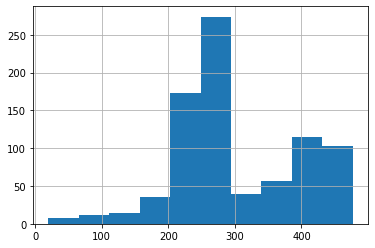

In [76]:
air_visit.groupby("air_store_id")['visit_date'].count().hist()

# There is one restuarnt which has less than 39 days information. Our goal is to forecast for 39 days.(1month+prev month last week)

In [77]:
air_visit.head(10)

,air_store_id,visit_date,visitors,holiday_flg,n_holidays,vacation_length,visit_month,visit_dow,visit_day,reserve_visitors_mean,reserve_visitors_max,reserve_visitors_min,reserve_visitors_sum,n_hrs_gap_mean,n_hrs_gap_max,n_hrs_gap_min,n_hrs_gap_sum,n_days_gap_mean,n_days_gap_max,n_days_gap_min,n_days_gap_sum,reserve_visitors_sum_rolling_7_mean,reserve_visitors_sum_rolling_7_std,reserve_visitors_sum_rolling_7_max,reserve_visitors_sum_rolling_7_min,reserve_visitors_sum_rolling_14_mean,reserve_visitors_sum_rolling_14_std,reserve_visitors_sum_rolling_14_max,reserve_visitors_sum_rolling_14_min,reserve_visitors_sum_rolling_30_mean,reserve_visitors_sum_rolling_30_std,reserve_visitors_sum_rolling_30_max,reserve_visitors_sum_rolling_30_min,n_hrs_gap_sum_rolling_7_mean,n_hrs_gap_sum_rolling_7_std,n_hrs_gap_sum_rolling_7_max,n_hrs_gap_sum_rolling_7_min,n_hrs_gap_sum_rolling_14_mean,n_hrs_gap_sum_rolling_14_std,n_hrs_gap_sum_rolling_14_max,n_hrs_gap_sum_rolling_14_min,n_hrs_gap_sum_rolling_30_mean,n_hrs_gap_sum_rolling_30_std,n_hrs_gap_sum_rolling_30_max,n_hrs_gap_sum_rolling_30_min,n_days_gap_sum_rolling_7_mean,n_days_gap_sum_rolling_7_std,n_days_gap_sum_rolling_7_max,n_days_gap_sum_rolling_7_min,n_days_gap_sum_rolling_14_mean,n_days_gap_sum_rolling_14_std,n_days_gap_sum_rolling_14_max,n_days_gap_sum_rolling_14_min,n_days_gap_sum_rolling_30_mean,n_days_gap_sum_rolling_30_std,n_days_gap_sum_rolling_30_max,n_days_gap_sum_rolling_30_min,reserve_visitors_sum_lag_1,reserve_visitors_sum_lag_2,reserve_visitors_sum_lag_3,reserve_visitors_sum_lag_4,reserve_visitors_sum_lag_5,reserve_visitors_sum_lag_6,reserve_visitors_sum_lag_7,n_hrs_gap_sum_lag_1,n_hrs_gap_sum_lag_2,n_hrs_gap_sum_lag_3,n_hrs_gap_sum_lag_4,n_hrs_gap_sum_lag_5,n_hrs_gap_sum_lag_6,n_hrs_gap_sum_lag_7,n_days_gap_sum_lag_1,n_days_gap_sum_lag_2,n_days_gap_sum_lag_3,n_days_gap_sum_lag_4,n_days_gap_sum_lag_5,n_days_gap_sum_lag_6,n_days_gap_sum_lag_7,air_genre_name,air_area_name,n_areas,count_res_per_genre_area,count_genres_per_area,visitors_lag_1,visitors_lag_2,visitors_lag_3,visitors_lag_4,visitors_lag_5,visitors_lag_6,visitors_lag_7
0,683,2016-01-01,7,1,3.0,3.0,1,4,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,7,99,1,3,35,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,290,2016-01-01,64,1,3.0,3.0,1,4,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,15,9,1,2,4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,741,2016-01-01,1,1,3.0,3.0,1,4,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,33,4,1,4,6,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,655,2016-01-01,31,1,3.0,3.0,1,4,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,90,1,4,30,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,26,2016-01-01,11,1,3.0,3.0,1,4,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1

In [78]:
import optuna
from sklearn.preprocessing import StandardScaler
PREDICTIVE_FEATURES=list(col for col in air_visit.columns.tolist() if col not in ["visit_date","visitors"])
PREDICTIVE_FEATURES

['air_store_id',
 'holiday_flg',
 'n_holidays',
 'vacation_length',
 'visit_month',
 'visit_dow',
 'visit_day',
 'reserve_visitors_mean',
 'reserve_visitors_max',
 'reserve_visitors_min',
 'reserve_visitors_sum',
 'n_hrs_gap_mean',
 'n_hrs_gap_max',
 'n_hrs_gap_min',
 'n_hrs_gap_sum',
 'n_days_gap_mean',
 'n_days_gap_max',
 'n_days_gap_min',
 'n_days_gap_sum',
 'reserve_visitors_sum_rolling_7_mean',
 'reserve_visitors_sum_rolling_7_std',
 'reserve_visitors_sum_rolling_7_max',
 'reserve_visitors_sum_rolling_7_min',
 'reserve_visitors_sum_rolling_14_mean',
 'reserve_visitors_sum_rolling_14_std',
 'reserve_visitors_sum_rolling_14_max',
 'reserve_visitors_sum_rolling_14_min',
 'reserve_visitors_sum_rolling_30_mean',
 'reserve_visitors_sum_rolling_30_std',
 'reserve_visitors_sum_rolling_30_max',
 'reserve_visitors_sum_rolling_30_min',
 'n_hrs_gap_sum_rolling_7_mean',
 'n_hrs_gap_sum_rolling_7_std',
 'n_hrs_gap_sum_rolling_7_max',
 'n_hrs_gap_sum_rolling_7_min',
 'n_hrs_gap_sum_rolling_14_me

In [79]:
import pickle

In [80]:
with open("predictive_features,.pkl",'wb') as f:
    pickle.dump(PREDICTIVE_FEATURES,f)

In [81]:
from sklearn.model_selection import TimeSeriesSplit

> models for experimenting
-> Xgboost
-> lightgbm
-> LSTM
-> Conv1D

# XGBOOST AND LIGHTGBM

In [ ]:
import xgboost as xgb

In [ ]:
air_visit['air_store_id'].nunique()*39

In [ ]:
air_visit.sort_values(by='visit_date',inplace=True,ignore_index=True)
x=air_visit[PREDICTIVE_FEATURES]
y=air_visit['visitors']
ts=TimeSeriesSplit(n_splits=3)
scores=[]
for i,(train,test) in enumerate(ts.split(X=x,y=y)):
    train_data=air_visit.loc[train]
    test_data=air_visit.loc[test]
    print("train")
    print(f"start date is {train_data.visit_date.min()} and end date is {train_data.visit_date.max()}")
    print("test")
    print(f"start date is {test_data.visit_date.min()} and end date is {test_data.visit_date.max()}")

In [ ]:
829*39

In [ ]:
air_visit.sort_values(by='visit_date',inplace=True,ignore_index=True)
x=air_visit[PREDICTIVE_FEATURES]
y=air_visit['visitors']
ts=TimeSeriesSplit(n_splits=3,test_size=32331)
scores=[]
for i,(train,test) in enumerate(ts.split(X=x,y=y)):
    train_data=air_visit.loc[train]
    test_data=air_visit.loc[test]
    print("train")
    print(f"start date is {train_data.visit_date.min()} and end date is {train_data.visit_date.max()}")
    print("test")
    print(f"start date is {test_data.visit_date.min()} and end date is {test_data.visit_date.max()}")

In [ ]:
air_visit.sort_values(by='visit_date',inplace=True,ignore_index=True)
x=air_visit[PREDICTIVE_FEATURES]
y=air_visit['visitors']
ts=TimeSeriesSplit(n_splits=5)
scores=[]
for i,(train,test) in enumerate(ts.split(X=x,y=y)):
    train_data=air_visit.loc[train]
    test_data=air_visit.loc[test]
    print("train")
    print(f"start date is {train_data.visit_date.min()} and end date is {train_data.visit_date.max()}")
    print("test")
    print(f"start date is {test_data.visit_date.min()} and end date is {test_data.visit_date.max()}")

In [ ]:
def objective(trial):
    max_depth=trial.suggest_int('max_depth',4,23)
    subsample=trial.suggest_discrete_uniform('subsample',0.6,0.95,0.01)
    colsample_bytree=trial.suggest_discrete_uniform('colsample_bytree',0.6,0.95,0.01)
    reg_lambda=trial.suggest_loguniform("reg_lambda", 1e-3, 10)
    min_child_weight=trial.suggest_int('min_child_weight',1,500,1)
    gamma=trial.suggest_loguniform("gamma", 1e-3, 10)
    lr=trial.suggest_uniform('learning_rate',0.01,0.3)
    n_estimators=trial.suggest_int('n_estimators',100,2000,50)
    air_visit.sort_values(by='visit_date',inplace=True,ignore_index=True)
    x=air_visit[PREDICTIVE_FEATURES]
    y=air_visit['visitors']
    ts=TimeSeriesSplit(n_splits=5)
    scores=[]
    for i,(train,test) in enumerate(ts.split(X=x,y=y)):
        train_data=air_visit.loc[train].reset_index(drop=True)
        test_data=air_visit.loc[test].reset_index(drop=True)
        scaler=StandardScaler()
        data=scaler.fit_transform(train_data.loc[:,PREDICTIVE_FEATURES])
        data=pd.DataFrame(data,columns=scaler.feature_names_in_)
        train_data=train_data.loc[:,['visit_date','visitors']].join(data)
        del data
        import gc
        gc.collect()
        ################
        data=scaler.transform(test_data.loc[:,PREDICTIVE_FEATURES])
        data=pd.DataFrame(data,columns=scaler.feature_names_in_)
        test_data=test_data.loc[:,['visit_date','visitors']].join(data)
        del data
        import gc
        gc.collect()
        model=xgb.XGBRegressor(max_depth=max_depth,subsample=subsample,learning_rate=lr,n_estimators=n_estimators,
                             objective='reg:squaredlogerror',tree_method='gpu_hist',
                             colsample_bytree=colsample_bytree,reg_lambda=reg_lambda,min_child_weight=min_child_weight,
                             gamma=gamma,early_stopping_rounds=100,random_state=42,eval_metric ='rmsle')
        model.fit(train_data.loc[:,PREDICTIVE_FEATURES],train_data['visitors'],
                eval_set=[(test_data.loc[:,PREDICTIVE_FEATURES],test_data['visitors'])],
                verbose=False)
        best_iter=model.best_iteration
        best_score=model.best_score
        if best_iter<100:
            scores.append(10)
        else:
            scores.append(best_score)
    return np.mean(scores)

In [ ]:
study=optuna.create_study(direction='minimize')
study.optimize(objective,n_trials=100,gc_after_trial=True,show_progress_bar=True)

In [ ]:
study.best_params

In [ ]:
study.best_value

In [ ]:
#0.5471758336621053
params={'max_depth': 13,
 'subsample': 0.88,
 'colsample_bytree': 0.8999999999999999,
 'reg_lambda': 2.7976677447481353,
 'min_child_weight': 1,
 'gamma': 0.10979160590981245,
 'learning_rate': 0.05009039381723597,
 'n_estimators': 850,
"random_state":42,
"objective":'reg:squaredlogerror',
"tree_method":'gpu_hist'
       }

In [ ]:
with open("xgboost_params.pkl","wb") as f:
    pickle.dump(params,f)

In [ ]:
air_visit.sort_values(by='visit_date',inplace=True,ignore_index=True)
x=air_visit[PREDICTIVE_FEATURES]
y=air_visit['visitors']
ts=TimeSeriesSplit(n_splits=5)
scores=[]
for i,(train,test) in enumerate(ts.split(X=x,y=y)):
    train_data=air_visit.loc[train].reset_index(drop=True)
    test_data=air_visit.loc[test].reset_index(drop=True)
    scaler=StandardScaler()
    data=scaler.fit_transform(train_data.loc[:,PREDICTIVE_FEATURES])
    data=pd.DataFrame(data,columns=scaler.feature_names_in_)
    train_data=train_data.loc[:,['visit_date','visitors']].join(data)
    del data
    import gc
    gc.collect()
    ################
    data=scaler.transform(test_data.loc[:,PREDICTIVE_FEATURES])
    data=pd.DataFrame(data,columns=scaler.feature_names_in_)
    test_data=test_data.loc[:,['visit_date','visitors']].join(data)
    del data
    import gc
    gc.collect()
    with open(f"scaler_fold_xgboost_{i}.pkl","wb") as f:
        pickle.dump(scaler,f)
    model=xgb.XGBRegressor(**params,early_stopping_rounds=100,eval_metric ='rmsle')
    model.fit(train_data.loc[:,PREDICTIVE_FEATURES],train_data['visitors'],
            eval_set=[(test_data.loc[:,PREDICTIVE_FEATURES],test_data['visitors'])],
            verbose=False)
    print(f"best iteration is {model.best_iteration}")
    model.save_model(f"xgboost_fold_{i}")
    best_score=model.best_score
    scores.append(best_score)
print(np.mean(scores))

In [ ]:
from lightgbm import LGBMRegressor,early_stopping,log_evaluation

In [ ]:
def objective(trial):
    max_depth=trial.suggest_int('max_depth',4,23)
    subsample=trial.suggest_discrete_uniform('subsample',0.6,0.95,0.01)
    colsample_bytree=trial.suggest_discrete_uniform('colsample_bytree',0.6,0.95,0.01)
    reg_lambda=trial.suggest_loguniform("reg_lambda", 1e-3, 10)
    num_leaves=trial.suggest_int("num_leaves",14,512,2)
    min_child_weight=trial.suggest_int('min_child_weight',1,500)
    lr=trial.suggest_uniform('learning_rate',0.01,0.1)
    air_visit.sort_values(by='visit_date',inplace=True,ignore_index=True)
    x=air_visit[PREDICTIVE_FEATURES]
    y=air_visit['visitors']
    ts=TimeSeriesSplit(n_splits=5)
    scores=[]
    for i,(train,test) in enumerate(ts.split(X=x,y=y)):
        train_data=air_visit.loc[train].reset_index(drop=True)
        test_data=air_visit.loc[test].reset_index(drop=True)
        scaler=StandardScaler()
        data=scaler.fit_transform(train_data.loc[:,PREDICTIVE_FEATURES])
        data=pd.DataFrame(data,columns=scaler.feature_names_in_)
        train_data=train_data.loc[:,['visit_date','visitors']].join(data)
        del data
        import gc
        gc.collect()
        ################
        data=scaler.transform(test_data.loc[:,PREDICTIVE_FEATURES])
        data=pd.DataFrame(data,columns=scaler.feature_names_in_)
        test_data=test_data.loc[:,['visit_date','visitors']].join(data)
        del data
        import gc
        gc.collect()
        model=LGBMRegressor(max_depth=max_depth,subsample=subsample,learning_rate=lr,n_estimators=2000,
                             objective='rmse',device_type = 'gpu',num_leaves=num_leaves,
                             colsample_bytree=colsample_bytree,reg_lambda=reg_lambda,min_child_weight=min_child_weight,
                             random_state=42,verbose= -100)
        model.fit(train_data.loc[:,PREDICTIVE_FEATURES],train_data['visitors'].apply(lambda x: np.log1p(x)),
                eval_set=[(test_data.loc[:,PREDICTIVE_FEATURES],test_data['visitors'].apply(lambda x: np.log1p(x)))],
                eval_metric='rmse',
                callbacks=[early_stopping(100),log_evaluation(0)])
        best_iter=model.best_iteration_
        best_score=model.best_score_['valid_0']['rmse']
        if best_iter<70:
            scores.append(10)
        else:
            scores.append(best_score)
    return np.mean(scores)

In [ ]:
study=optuna.create_study(direction='minimize')
study.optimize(objective,n_trials=100,gc_after_trial=True,show_progress_bar=True)

In [ ]:
study.best_params

In [ ]:
study.best_value

In [ ]:
#0.5395372696221257
params={'max_depth': 23, 'subsample': 0.7, 'colsample_bytree': 0.6, 'reg_lambda': 0.43174337266180896, 
                'num_leaves': 96, 'min_child_weight': 5, 'learning_rate': 0.019784123184400926,
 "objective":'rmse',"device_type" : 'gpu',"random_state":42,
       "n_estimators":2000,"verbose": -100}

In [ ]:
with open("lgb_params.pkl","wb") as f:
    pickle.dump(params,f)

In [ ]:
air_visit.sort_values(by='visit_date',inplace=True,ignore_index=True)
x=air_visit[PREDICTIVE_FEATURES]
y=air_visit['visitors']
ts=TimeSeriesSplit(n_splits=5)
scores=[]
for i,(train,test) in enumerate(ts.split(X=x,y=y)):
    train_data=air_visit.loc[train].reset_index(drop=True)
    test_data=air_visit.loc[test].reset_index(drop=True)
    scaler=StandardScaler()
    data=scaler.fit_transform(train_data.loc[:,PREDICTIVE_FEATURES])
    data=pd.DataFrame(data,columns=scaler.feature_names_in_)
    train_data=train_data.loc[:,['visit_date','visitors']].join(data)
    del data
    import gc
    gc.collect()
    ################
    data=scaler.transform(test_data.loc[:,PREDICTIVE_FEATURES])
    data=pd.DataFrame(data,columns=scaler.feature_names_in_)
    test_data=test_data.loc[:,['visit_date','visitors']].join(data)
    del data
    import gc
    gc.collect()
    with open(f"scaler_fold_lightgbm_{i}.pkl","wb") as f:
        pickle.dump(scaler,f)
    model=LGBMRegressor(**params)
    model.fit(train_data.loc[:,PREDICTIVE_FEATURES],train_data['visitors'].apply(lambda x: np.log1p(x)),
            eval_set=[(test_data.loc[:,PREDICTIVE_FEATURES],test_data['visitors'].apply(lambda x: np.log1p(x)))],
            eval_metric='rmse',
            callbacks=[early_stopping(100),log_evaluation(0)])
    best_iter=model.best_iteration_
    best_score=model.best_score_['valid_0']['rmse']
    print(f"best iteration is {best_iter}")
    model.booster_.save_model(f"lightgbm_fold_{i}")
    scores.append(best_score)
print(np.mean(scores))

# DEEP LEARNING

In [82]:
import tensorflow as tf

# for lstm window data creator

In [83]:
class INPUT_GENERATOR(tf.keras.utils.Sequence):
    def __init__(self,dataframe,categorial_cols,numeric_cols,target_feature,shuffle,batch_size,window_size,indices):
        self.dataframe=dataframe
        self.categorial_cols=categorial_cols
        self.numeric_cols=numeric_cols
        self.target_feature=target_feature
        self.shuffle=shuffle
        self.batch_size=batch_size
        self.window_size=window_size
        self.dataframe.sort_values(by=["air_store_id",'visit_date'],inplace=True,ignore_index=True)
        self.indices=self.get_indices() if indices==None else indices
        self.temp_indices=np.arange(len(self.indices))
        self.max_=self.__len__()
        self.iterator=0
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.indices)/self.batch_size))
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.temp_indices)
    
    def get_indices(self):
        indices=[]
        for grp in self.dataframe['air_store_id'].unique():
            indices.extend(self.dataframe.loc[self.dataframe['air_store_id']==grp].iloc[:-(self.window_size-1)].index.tolist())
        return indices
    
    def __next__(self):
        if self.iterator>self.max_:
            self.iterator=0
            result=self.__getitem__(self.iterator)
        else:
            result=self.__getitem__(self.iterator)
        self.iterator+=1
        return result
    
    def __getitem__(self,batch):
        curr_temp_indices=self.temp_indices[batch*self.batch_size:(batch+1)*self.batch_size]
        curr_indices=list(self.indices[i] for i in curr_temp_indices)
        assert len(curr_indices)==self.batch_size
        X={}
        X['numeric']=np.empty((self.batch_size,self.window_size-1,len(self.numeric_cols)))
        for col in self.categorial_cols:
            X[col]=np.empty((self.batch_size,self.window_size-1))
        Y=np.empty((self.batch_size,))
        for i,idx in enumerate(curr_indices):
            start_index=idx
            end_index=idx+self.window_size
            window_data=self.dataframe.iloc[start_index:end_index].reset_index(drop=True)
            assert window_data['air_store_id'].nunique()==1,"arrange data by air_store_id"
            X['numeric'][i,]=window_data.iloc[:-1][self.numeric_cols].values
            for col in self.categorial_cols:
                X[col][i,]=window_data.iloc[:-1][col].values
            Y[i,]=window_data.iloc[-1][self.target_feature]
        return X,Y

In [84]:
import optuna
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Embedding,BatchNormalization,Dense,ReLU,Dropout

In [85]:
def Embedding_out_dim(n_cat):
    return min(600, round(1.6 * n_cat ** .56))

In [86]:
categorical_columns=['air_store_id','visit_month','visit_dow','visit_day','air_genre_name','air_area_name']
embedding_dims={}
for col in categorical_columns:
    n_uni=air_visit[col].nunique()
    if 0 in air_visit[col].unique():
        out_size=Embedding_out_dim(n_uni)
        embedding_dims[col]={'input_dim':n_uni,"out_dim":out_size}
    else:
        out_size=Embedding_out_dim(n_uni+1)
        embedding_dims[col]={'input_dim':n_uni+1,"out_dim":out_size}
embedding_dims

{'air_store_id': {'input_dim': 829, 'out_dim': 69},
 'visit_month': {'input_dim': 13, 'out_dim': 7},
 'visit_dow': {'input_dim': 7, 'out_dim': 5},
 'visit_day': {'input_dim': 32, 'out_dim': 11},
 'air_genre_name': {'input_dim': 36, 'out_dim': 12},
 'air_area_name': {'input_dim': 135, 'out_dim': 25}}

In [87]:
numerical_columns=list(col for col in PREDICTIVE_FEATURES if col not in categorical_columns)

In [88]:
gen=INPUT_GENERATOR(dataframe=air_visit,
                    categorial_cols=categorical_columns,numeric_cols=numerical_columns,
                    target_feature='visitors',shuffle=True,batch_size=32,window_size=20,indices=None)

In [89]:
inputs,outputs=next(gen)
for key,values in inputs.items():
    print(f"for type {key} shape is {values.shape}")
print(f"outputs shape is {outputs.shape}")

for type numeric shape is (32, 19, 82)
for type air_store_id shape is (32, 19)
for type visit_month shape is (32, 19)
for type visit_dow shape is (32, 19)
for type visit_day shape is (32, 19)
for type air_genre_name shape is (32, 19)
for type air_area_name shape is (32, 19)
outputs shape is (32,)


In [90]:
def RMSLE(y_true,y_pred):
    y_true=tf.cast(y_true,dtype=y_pred.dtype)
    log_1p_y_true=tf.keras.backend.log(1.0+y_true)
    log_1p_y_pred=tf.keras.backend.log(1.0+y_pred)
    sq_diff=tf.reduce_mean(tf.keras.backend.square(log_1p_y_true-log_1p_y_pred),axis=-1)
    mean_value=tf.reduce_mean(sq_diff,axis=-1)
    return mean_value**0.5

In [91]:
def Make_LSTM_Model(parameters):
    window_size=parameters['window_size']
    lstm_n_layers=parameters['lstm_n_layers']
    dense_layers=parameters['dense_layers']
    lstm_units=parameters['lstm_units']
    dense_units=parameters['dense_units']
    ins_dict={}
    embed_layers={}
    ins_dict['numeric']=Input((window_size,len(numerical_columns)),name='numerical')
    for col,dims in embedding_dims.items():
        ins_dict[col]=Input((window_size,),name=f"ins_{col}")
        embed_layers[col]=Embedding(input_dim=dims['input_dim'],output_dim=dims['out_dim'],
                                    input_length=window_size,name=f"embedding_{col}")(ins_dict[col])
    concat_layer=tf.keras.layers.Concatenate()
    l=[ins_dict['numeric']]
    for col,layer in embed_layers.items():
        l.append(layer)
    x=concat_layer(l)
    for layer in range(lstm_n_layers):
        if layer!=lstm_n_layers-1:
            x=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units[layer],return_sequences=True))(x)
            #x=tf.keras.layers.SpatialDropout1D(0.1)(x)
        else:
            x=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units[layer]))(x)
    #x=tf.keras.layers.Dropout(0.1)(x)
    if dense_layers>0:
        for layer in range(dense_layers):
            x=Dense(dense_units[layer])(x)
            x=BatchNormalization()(x)
            x=ReLU()(x)
            #x=tf.keras.layers.Dropout(0.1)(x)
    outs=Dense(1,activation="relu")(x)
    model=Model(inputs=ins_dict,outputs=outs)
    return model

In [92]:
Make_LSTM_Model({"window_size":19,"lstm_n_layers":2,"lstm_units":[20,20],"dense_layers":1,"dense_units":[5]}).summary()

2022-07-12 06:47:24.544189: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-12 06:47:24.677720: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-12 06:47:24.678979: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-12 06:47:24.681111: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ins_air_store_id (InputLayer)   [(None, 19)]         0                                            
__________________________________________________________________________________________________
ins_visit_month (InputLayer)    [(None, 19)]         0                                            
__________________________________________________________________________________________________
ins_visit_dow (InputLayer)      [(None, 19)]         0                                            
__________________________________________________________________________________________________
ins_visit_day (InputLayer)      [(None, 19)]         0                                            
______________________________________________________________________________________________

In [93]:
def Make_Model(parameters):
    n_layers=parameters['n_layers']
    units=parameters['units']
    drop_or_not_dict=parameters['drop_or_not_dict']
    drop_rate_dict=parameters['drop_rate_dict']
    ins_dict={}
    embed_layers={}
    ins_dict['numeric']=Input((len(numerical_columns,)),name='numerical')
    for col,dims in embedding_dims.items():
        ins_dict[col]=Input((1,),name=f"ins_{col}")
        embed_layers[col]=Embedding(input_dim=dims['input_dim'],output_dim=dims['out_dim'],input_length=1,name=f"embedding_{col}")(ins_dict[col])[:,0,:]
    concat_layer=tf.keras.layers.Concatenate()
    l=[ins_dict['numeric']]
    for col,layer in embed_layers.items():
        l.append(layer)
    x=concat_layer(l)
    for layer in range(n_layers):
        x=Dense(units[layer],kernel_initializer='he_normal')(x)
        x=BatchNormalization()(x)
        x=ReLU()(x)
        if layer%2!=0 and layer!=n_layers-1:
            drop_or_not=drop_or_not_dict[layer]
            if drop_or_not:
                drop_rate=drop_rate_dict[layer]
                x=Dropout(drop_rate)(x)
    outs=Dense(1,activation='relu')(x)
    model=Model(inputs=ins_dict,outputs=outs)
    return model

# NN

In [94]:
def Objective(trial):
    n_layers=trial.suggest_int("n_layers",2,4)
    units=[]
    drop_or_not_dict={}
    drop_rate_dict={}
    for i in range(n_layers):
        unit=trial.suggest_int(f"units_{i}",20,150,10)
        units.append(unit)
        if i%2!=0 and i!=n_layers-1:
            drop_or_not=trial.suggest_categorical(f"drop_or_not_{i}",[True,False])
            drop_or_not_dict[i]=drop_or_not
            if drop_or_not:
                drop_rate=trial.suggest_float(f"drop_rate_{i}",low=0.1,high=0.6,step=0.01)
                drop_rate_dict[i]=drop_rate
    parameters={"n_layers":n_layers,"units":units,"drop_or_not_dict":drop_or_not_dict,"drop_rate_dict":drop_rate_dict}
    air_visit.sort_values(by='visit_date',inplace=True,ignore_index=True)
    x=air_visit[PREDICTIVE_FEATURES]
    y=air_visit['visitors']
    scores=[]
    ts=TimeSeriesSplit(n_splits=5,test_size=32331)
    for i,(train,test) in enumerate(ts.split(X=x,y=y)):
        train_data=air_visit.loc[train].reset_index(drop=True)
        test_data=air_visit.loc[test].reset_index(drop=True)
        scaler=StandardScaler()
        data=scaler.fit_transform(train_data.loc[:,numerical_columns])
        data=pd.DataFrame(data,columns=scaler.feature_names_in_)
        train_data=train_data.loc[:,categorical_columns+['visit_date','visitors']].join(data)
        del data
        import gc
        gc.collect()
        ################
        data=scaler.transform(test_data.loc[:,numerical_columns])
        data=pd.DataFrame(data,columns=scaler.feature_names_in_)
        test_data=test_data.loc[:,categorical_columns+['visit_date','visitors']].join(data)
        del data
        import gc
        gc.collect()
        train_ins_features={}
        for col in categorical_columns:
            train_ins_features[col]=np.expand_dims(train_data[col].values,axis=-1)
        train_ins_features['numeric']=train_data.loc[:,numerical_columns].values
        test_ins_features={}
        for col in categorical_columns:
            test_ins_features[col]=np.expand_dims(test_data[col].values,axis=-1)
        test_ins_features['numeric']=test_data.loc[:,numerical_columns].values
        fix_random()
        tf.keras.backend.clear_session()
        model=Make_Model(parameters)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
                     loss=RMSLE)
        early=tf.keras.callbacks.EarlyStopping(patience=3,monitor="val_loss",mode='min',verbose=1,restore_best_weights=True)
        model.fit(train_ins_features,train_data['visitors'].values,
                 validation_data=(test_ins_features,test_data['visitors'].values),batch_size=1024,
                 epochs=50,callbacks=[early],verbose=False)
        if np.argmin(model.history.history['val_loss'])<3:
            scores.append(10)
        else:
            scores.append(model.evaluate(test_ins_features,test_data['visitors'].values,batch_size=1024))
        del model
        import gc
        gc.collect()
    return np.mean(scores)

# LSTM

In [95]:
def find_batches(data):
    return np.where((data['air_store_id'].value_counts()/20).values>=1)[0].shape

In [96]:
x=air_visit[PREDICTIVE_FEATURES]
y=air_visit['visitors']
scores=[]
ts=TimeSeriesSplit(n_splits=3,test_size=33160)
for i,(train,test) in enumerate(ts.split(X=x,y=y)):
    train_data=air_visit.loc[train].reset_index(drop=True)
    test_data=air_visit.loc[test].reset_index(drop=True)
    print(f"for train {i} we got {find_batches(train_data)} grps satisfing window size and total stores are {train_data['air_store_id'].nunique()}")
    print(f"for test {i} we got {find_batches(test_data)} and total stores are {test_data['air_store_id'].nunique()}")

for train 0 we got (499,) grps satisfing window size and total stores are 499
for test 0 we got (115,) and total stores are 115
for train 1 we got (613,) grps satisfing window size and total stores are 613
for test 1 we got (109,) and total stores are 109
for train 2 we got (721,) grps satisfing window size and total stores are 721
for test 2 we got (109,) and total stores are 109


In [97]:
def Objective(trial):
    lstm_n_layers=trial.suggest_int("lstm_n_layers",1,3)
    dense_layers=trial.suggest_int("dense_layers",0,2)
    lstm_units=[]
    dense_units=[]
    for i in range(lstm_n_layers):
        unit=trial.suggest_int(f"lstm_units{i}",20,50,5)
        lstm_units.append(unit)
    if dense_layers>0:
        for i in range(dense_layers):
            unit=trial.suggest_int(f"dense_units{i}",5,30,5)
            dense_units.append(unit)
    parameters={"window_size":19,"lstm_n_layers":lstm_n_layers,"lstm_units":lstm_units,
                "dense_layers":dense_layers,"dense_units":dense_units}
    air_visit.sort_values(by='visit_date',inplace=True,ignore_index=True)
    x=air_visit[PREDICTIVE_FEATURES]
    y=air_visit['visitors']
    ts=TimeSeriesSplit(n_splits=3,test_size=33160)
    for i,(train,test) in enumerate(ts.split(X=x,y=y)):
        if i==2:
            train_data=air_visit.loc[train].reset_index(drop=True)
            test_data=air_visit.loc[test].reset_index(drop=True)
            scaler=StandardScaler()
            data=scaler.fit_transform(train_data.loc[:,numerical_columns])
            data=pd.DataFrame(data,columns=scaler.feature_names_in_)
            train_data=train_data.loc[:,categorical_columns+['visit_date','visitors']].join(data)
            del data
            import gc
            gc.collect()
            ################
            data=scaler.transform(test_data.loc[:,numerical_columns])
            data=pd.DataFrame(data,columns=scaler.feature_names_in_)
            test_data=test_data.loc[:,categorical_columns+['visit_date','visitors']].join(data)
            del data
            import gc
            gc.collect()
            train_gen=INPUT_GENERATOR(dataframe=train_data,
                        categorial_cols=categorical_columns,numeric_cols=numerical_columns,
                        target_feature='visitors',shuffle=True,batch_size=1024,window_size=20,indices=FOLD_INDEXES[i]['train'])
            test_gen=INPUT_GENERATOR(dataframe=test_data,
                        categorial_cols=categorical_columns,numeric_cols=numerical_columns,
                        target_feature='visitors',shuffle=False,batch_size=1024,window_size=20,indices=FOLD_INDEXES[i]['test'])

            fix_random()
            tf.keras.backend.clear_session()
            model=Make_LSTM_Model(parameters)
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
                         loss=RMSLE)
            early=tf.keras.callbacks.EarlyStopping(patience=3,monitor="val_loss",mode='min',verbose=1,restore_best_weights=True)
            model.fit(train_gen,
                     validation_data=test_gen,
                     epochs=30,callbacks=[early])
            if np.argmin(model.history.history['val_loss'])<3:
                score=10
            else:
                score= model.evaluate(test_gen)
            del model
            import gc
            gc.collect()
    return score

In [98]:
#FOLD_INDEXES={0:{"train":None,"test":None},1:{"train":None,"test":None},2:{"train":None,"test":None}}
#study=optuna.create_study()
#study.optimize(Objective,n_trials=100,gc_after_trial=True,show_progress_bar=True)

# NN

In [ ]:
#parameters={"n_layers":n_layers,"units":units,"drop_or_not_dict":drop_or_not_dict,"drop_rate_dict":drop_rate_dict}
#In First iterations found having layers 2 to 3 giving better results. So, now going to update the parameters search space. and increase epochs.
#parameters={"n_layers": 2,"units":[140,30],"drop_or_not_dict":{},"drop_rate_dict":{}}
#0.5180848240852356
{'n_layers': 4, 'units_0': 140, 'units_1': 110, 'drop_or_not_1': True, 'drop_rate_1': 0.30000000000000004, 'units_2': 40, 'units_3': 20}
parameters={"n_layers":4,"units":[140,110,40,20],'drop_or_not_dict':{1: True}, 'drop_rate_dict':{1: 0.30000000000000004}}
#parameters={'n_layers': 3, 'units': [110,120,120],'drop_or_not_dict':{1: True}, 'drop_rate_dict':{1: 0.25}}

In [ ]:
for lr in [1e-3,3e-4,1e-4,3e-5]:
    air_visit.sort_values(by='visit_date',inplace=True,ignore_index=True)
    x=air_visit[PREDICTIVE_FEATURES]
    y=air_visit['visitors']
    scores=[]
    ts=TimeSeriesSplit(n_splits=5,test_size=32331)
    scores=[]
    for i,(train,test) in enumerate(ts.split(X=x,y=y)):
        train_data=air_visit.loc[train].reset_index(drop=True)
        test_data=air_visit.loc[test].reset_index(drop=True)
        scaler=StandardScaler()
        data=scaler.fit_transform(train_data.loc[:,numerical_columns])
        data=pd.DataFrame(data,columns=scaler.feature_names_in_)
        train_data=train_data.loc[:,categorical_columns+['visit_date','visitors']].join(data)
        del data
        import gc
        gc.collect()
        ################
        with open(f"scaler_fold_NN_{lr}_{i}.pkl","wb") as f:
            pickle.dump(scaler,f)
        data=scaler.transform(test_data.loc[:,numerical_columns])
        data=pd.DataFrame(data,columns=scaler.feature_names_in_)
        test_data=test_data.loc[:,categorical_columns+['visit_date','visitors']].join(data)
        del data
        import gc
        gc.collect()
        train_ins_features={}
        for col in categorical_columns:
            train_ins_features[col]=np.expand_dims(train_data[col].values,axis=-1)
        train_ins_features['numeric']=train_data.loc[:,numerical_columns].values
        test_ins_features={}
        for col in categorical_columns:
            test_ins_features[col]=np.expand_dims(test_data[col].values,axis=-1)
        test_ins_features['numeric']=test_data.loc[:,numerical_columns].values
        fix_random()
        tf.keras.backend.clear_session()
        model=Make_Model(parameters)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                     loss=RMSLE)
        early=tf.keras.callbacks.EarlyStopping(patience=3,monitor="val_loss",mode='min',verbose=1,restore_best_weights=True)
        saver=tf.keras.callbacks.ModelCheckpoint(monitor="val_loss",mode='min',verbose=0,save_best_only=True,save_weights_only=True,
                                                 filepath=f'nn_2_layers_{lr}_{i}.h5')
        model.fit(train_ins_features,train_data['visitors'].values,
                 validation_data=(test_ins_features,test_data['visitors'].values),batch_size=1024,
                 epochs=50,callbacks=[early,saver],verbose=False)
        scores.append(model.evaluate(test_ins_features,test_data['visitors'].values,batch_size=1024))
        del model
        import gc
        gc.collect()
    print(f"for lr: {lr} we got {np.mean(scores)}")
    scores=[]

# LSTM

In [99]:
parameters={"window_size":19,"lstm_n_layers":2,"lstm_units":[30,30],"dense_layers":1,"dense_units":[30]}

In [100]:
lr=1e-3

In [101]:
FOLD_INDEXES={0:{"train":None,"test":None},1:{"train":None,"test":None},2:{"train":None,"test":None}}

In [102]:
air_visit.sort_values(by='visit_date',inplace=True,ignore_index=True)
x=air_visit[PREDICTIVE_FEATURES]
y=air_visit['visitors']
ts=TimeSeriesSplit(n_splits=3,test_size=33160)
for i,(train,test) in enumerate(ts.split(X=x,y=y)):
    if i==2:
        train_data=air_visit.loc[train].reset_index(drop=True)
        test_data=air_visit.loc[test].reset_index(drop=True)
        scaler=StandardScaler()
        data=scaler.fit_transform(train_data.loc[:,numerical_columns])
        data=pd.DataFrame(data,columns=scaler.feature_names_in_)
        train_data=train_data.loc[:,categorical_columns+['visit_date','visitors']].join(data)
        del data
        import gc
        gc.collect()
        ################
        data=scaler.transform(test_data.loc[:,numerical_columns])
        data=pd.DataFrame(data,columns=scaler.feature_names_in_)
        test_data=test_data.loc[:,categorical_columns+['visit_date','visitors']].join(data)
        del data
        import gc
        gc.collect()
        with open(f"scaler_lstm_{lr}_{i}.pkl","wb") as f:
            pickle.dump(scaler,f)
        train_gen=INPUT_GENERATOR(dataframe=train_data,
                    categorial_cols=categorical_columns,numeric_cols=numerical_columns,
                    target_feature='visitors',shuffle=True,batch_size=1024,window_size=20,indices=FOLD_INDEXES[i]['train'])
        test_gen=INPUT_GENERATOR(dataframe=test_data,
                    categorial_cols=categorical_columns,numeric_cols=numerical_columns,
                    target_feature='visitors',shuffle=False,batch_size=1024,window_size=20,indices=FOLD_INDEXES[i]['test'])
        fix_random()
        tf.keras.backend.clear_session()
        model=Make_LSTM_Model(parameters)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                     loss=RMSLE)
        early=tf.keras.callbacks.EarlyStopping(patience=3,monitor="val_loss",mode='min',verbose=1,restore_best_weights=True)
        saver=tf.keras.callbacks.ModelCheckpoint(monitor="val_loss",mode='min',verbose=1,save_best_only=True,save_weights_only=True,
                            filepath=f'lstm_2_dense_1.h5')
        model.fit(train_gen,
                 validation_data=test_gen,
                 epochs=50,callbacks=[early,saver])
        if np.argmin(model.history.history['val_loss'])<3:
            score=10
        else:
            score= model.evaluate(test_gen)
        del model
        import gc
        gc.collect()
print(score)

2022-07-12 06:47:36.953866: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-07-12 06:47:47.815839: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


198/198 [==============================] - 610s 3s/step - loss: 1.4685 - val_loss: 1.2034

Epoch 00001: val_loss improved from inf to 1.20340, saving model to lstm_2_dense_1.h5
Epoch 2/50
198/198 [==============================] - 587s 3s/step - loss: 0.9461 - val_loss: 0.7823

Epoch 00002: val_loss improved from 1.20340 to 0.78225, saving model to lstm_2_dense_1.h5
Epoch 3/50
198/198 [==============================] - 579s 3s/step - loss: 0.7019 - val_loss: 0.6166

Epoch 00003: val_loss improved from 0.78225 to 0.61658, saving model to lstm_2_dense_1.h5
Epoch 4/50
198/198 [==============================] - 582s 3s/step - loss: 0.5959 - val_loss: 0.5687

Epoch 00004: val_loss improved from 0.61658 to 0.56873, saving model to lstm_2_dense_1.h5
Epoch 5/50
198/198 [==============================] - 581s 3s/step - loss: 0.5598 - val_loss: 0.5452

Epoch 00005: val_loss improved from 0.56873 to 0.54522, saving model to lstm_2_dense_1.h5
Epoch 6/50
198/198 [==============================] - 5

In [ ]:
#exp
2 lstm: 30
1 dense: 30
error->0.5143401026725769
2 dense: 30,15
error->0.5163817405700684
2 lstm: 30
dense: 0
error->0.5212774872779846
######add dropouts
1 dense: 30
error->0.5271048545837402
#######only dropout after lstm
1 dense: 30
error->0.5155584812164307